# Named Entity Recognition

Hi 🙂, if you are seeing this notebook, you have succesfully started your first project on FloydHub 🚀, hooray!!

[Named Enity Recognition](https://en.wikipedia.org/wiki/Named-entity_recognition) is one of the most common [NLP](https://en.wikipedia.org/wiki/Natural-language_processing) problems. The goal is classify named entities in text into pre-defined categories such as the names of persons, organizations, locations, expressions of times, quantities, monetary values, percentages, etc.
*What can you use it for?* Here are a few ideas - social media, chatbot, customer support tickets, survey responses, and data mining! 

### Predicting named entities of GMB(Groningen Meaning Bank) corpus

In this notebook we will perform a [Sequence Tagging with a LSTM-CRF model](https://www.depends-on-the-definition.com/sequence-tagging-lstm-crf/) to extract the named entities from the annotated corpus.

<img src="https://raw.githubusercontent.com/floydhub/named-entity-recognition-template/master/images/ner-image.png" width="800" height="800" align="center"/>

Entity tags are encoded using a BIO annotation scheme, where each entity label is prefixed with either B or I letter. B- denotes the beginning and I- inside of an entity. The prefixes are used to detect multiword entities, e.g. sentence:"World War II", tags:(B-eve, I-eve, I-eve). All other words, which don’t refer to entities of interest, are labeled with the O tag.

Tag | Label meaning | Example Given
------------ | ------------- | 
geo | Geographical Entity | London
org | Organization | ONU
per | Person | Bush
gpe | Geopolitical Entity | British
tim | Time indicator | Wednesday
art | Artifact | Chrysler
eve | Event | Christmas
nat | Natural Phenomenon | Hurricane
O | No-Label | the

We will:
- Preprocess text data for NLP
- Build and train a Bi-directional LSTM-CRF model using Keras and Tensorflow
- Evaluate our model on the test set
- Run the model on your own sentences!

#### Instructions
- To execute a code cell, click on the cell and press `Shift + Enter` (shortcut for Run).
- To learn more about Workspaces, check out the [Getting Started Notebook](get_started_workspace.ipynb).
- **Tip**: *Feel free to try this Notebook with your own data and on your own super awesome named entity recognition task.*

Now, let's get started! 🚀

### Initial Setup
Let's start by importing some packages.

In [1]:
# Install extra-dependencies
! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite

In [2]:
import tensorflow as tf
import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Training Parameters
We'll set the hyperparameters for training our model. If you understand what they mean, feel free to play around - otherwise, we recommend keeping the defaults for your first run 🙂

In [3]:
# Hyperparams if GPU is available
if tf.test.is_gpu_available():
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    EMBEDDING = 40  # Dimension of word embedding vector

    
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    EMBEDDING = 20

## Data

The movie ner dataset is already attached to your workspace (if you want to attach your own data, [check out our docs](https://docs.floydhub.com/guides/workspace/#attaching-floydhub-datasets)).

Let's take a look at data.

In [4]:
data = pd.read_csv("/floyd/input/ner/ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=10) 

Number of sentences:  47959
Number of words in the dataset:  35178
Tags: ['O', 'I-nat', 'I-eve', 'B-nat', 'I-art', 'B-gpe', 'I-org', 'I-gpe', 'B-per', 'I-per', 'B-eve', 'I-tim', 'B-geo', 'I-geo', 'B-org', 'B-art', 'B-tim']
Number of Labels:  17
What the dataset looks like:


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [5]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


As you can see from the output Cell above, each sentence in the dataset is represented as a list of tuple: [`(Token_1, PoS_1, Tag_1)`, ..., `(Token_n, PoS_n, Tag_n)`].

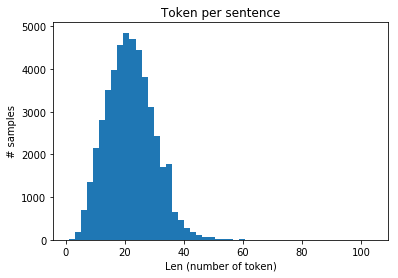

In [6]:
# Get all the sentences
sentences = getter.sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

## Data Preprocessing

Before feeding the data into the model, we have to preprocess the text.

- We will use the `word2idx` dictionary to convert each word to a corresponding integer ID and the `tag2idx` to do the same for the labels. Representing words as integers saves a lot of memory!
- In order to feed the text into our Bi-LSTM-CRF, all texts should be the same length. We ensure this using the `sequence.pad_sequences()` method and `MAX_LEN` variable. All texts longer than `MAX_LEN` are truncated and shorter texts are padded to get them to the same length.

The *Tokens per sentence* plot (see above) is useful for setting the `MAX_LEN` training hyperparameter.

In [7]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

print("The word Obama is identified by the index: {}".format(word2idx["Obama"]))
print("The labels B-geo(which defines Geopraphical Enitities) is identified by the index: {}".format(tag2idx["B-geo"]))


from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X = pad_sequences(maxlen=MAX_LEN, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"])

from keras.utils import to_categorical
# One-Hot encode
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1)
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))
print('After processing, sample:', X[0])
print('After processing, labels:', y[0])

The word Obama is identified by the index: 9881
The labels B-geo(which defines Geopraphical Enitities) is identified by the index: 13
Raw Sample:  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
Raw Label:  O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O
After processing, sample: [16817  7825 10253 17489    66 10783  7144 32555  6507  8582  7721 25544
 28446  2656 25382  8582 32363  7825 23884 21607 15364 29850 18029  8610
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
After processing, labels: [[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0.

## Model

We will implement a model similar to Zhiheng Huang’s [Bidirectional LSTM-CRF Models for Sequence Tagging](https://arxiv.org/pdf/1508.01991v1.pdf).

<img src="https://raw.githubusercontent.com/floydhub/named-entity-recognition-template/master/images/bilstm-crf.png" width="400" height="400" align="center"/>

*Image from [the paper](https://arxiv.org/pdf/1508.01991v1.pdf)*

In [8]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 75, 20)            703600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 75, 100)           28400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 75, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 75, 18)            1278      
Total params: 738,328
Trainable params: 738,328
Non-trainable params: 0
_________________________________________________________________


## Training & Evaluate

The Training is defined at the beginning by the type of instance on which runs:

- On CPU machine: 25 minutes for 5 epochs.
- On GPU machine: 5 minute for 5 epochs.

*Note*: Accuracy isn't the best metric to choose for evaluating this type of task because most of the time it will correctly predict '**O**' or '**PAD**' without identifing the important Tags, which are the ones we are interested in. So after training for some epochs, we can monitor the **precision**, **recall** and **f1-score** for each of the Tags.

In [9]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_split=0.1, verbose=2)

Train on 38846 samples, validate on 4317 samples
Epoch 1/5
38846/38846 [==============================] - 254s 7ms/step - loss: 9.1008 - acc: 0.9034 - val_loss: 9.0202 - val_acc: 0.9517
Epoch 2/5
38846/38846 [==============================] - 247s 6ms/step - loss: 8.8708 - acc: 0.9589 - val_loss: 8.9733 - val_acc: 0.9625
Epoch 3/5
38846/38846 [==============================] - 246s 6ms/step - loss: 8.8402 - acc: 0.9668 - val_loss: 8.9584 - val_acc: 0.9648
Epoch 4/5
38846/38846 [==============================] - 248s 6ms/step - loss: 8.8287 - acc: 0.9703 - val_loss: 8.9542 - val_acc: 0.9654
Epoch 5/5
38846/38846 [==============================] - 249s 6ms/step - loss: 8.8227 - acc: 0.9721 - val_loss: 8.9500 - val_acc: 0.9681


In [10]:
# Eval
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, -1)

In [11]:
from sklearn_crfsuite.metrics import flat_classification_report

# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)

             precision    recall  f1-score   support

      B-art       0.00      0.00      0.00        52
      B-eve       1.00      0.33      0.50        15
      B-geo       0.86      0.90      0.88      3677
      B-gpe       0.97      0.93      0.95      1570
      B-nat       0.00      0.00      0.00        22
      B-org       0.74      0.73      0.74      2012
      B-per       0.82      0.82      0.82      1726
      B-tim       0.93      0.87      0.90      2063
      I-art       0.00      0.00      0.00        36
      I-eve       0.00      0.00      0.00        11
      I-geo       0.83      0.77      0.80       696
      I-gpe       0.92      0.57      0.71        21
      I-nat       0.00      0.00      0.00         8
      I-org       0.74      0.81      0.77      1657
      I-per       0.87      0.90      0.88      1835
      I-tim       0.84      0.73      0.78       642
          O       0.99      0.99      0.99     88839
        PAD       1.00      1.00      1.00   

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Evaluate some samples in the test set. (At each execution it will test on a different sample).

In [12]:
i = np.random.randint(0,X_te.shape[0]) # choose a random number between 0 and len(X_te)
p = model.predict(np.array([X_te[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_te[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_te.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_te[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

Sample number 2106 of 4796 (Test Set)
Word           ||True ||Pred
He             : O     O
said           : O     O
,              : O     O
however        : O     O
,              : O     O
the            : O     O
world          : O     O
body           : O     O
remains        : O     O
committed      : O     O
to             : O     O
work           : O     O
for            : O     O
peace          : O     O
in             : O     O
such           : O     O
places         : O     O
as             : O     O
Lebanon        : B-geo B-geo
,              : O     O
Darfur         : B-geo B-geo
,              : O     O
Haiti          : B-geo B-geo
and            : O     O
Iraq           : B-geo B-geo
.              : O     O


## It's your turn

Test out the model you just trained. Run the code Cell below and type your reviews in the widget, Have fun!🎉

Here are some inspirations:

- Obama was the president of USA.
- The 1906 San Francisco earthquake was the biggest earthquake that has ever hit San Francisco on April 18, 1906
- Next Monday is Christmas!

Can you do better? Play around with the model hyperparameters!

In [13]:
from ipywidgets import interact_manual
from ipywidgets import widgets

import re
import string

# Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()
    
def get_prediction(sentence):
    test_sentence = tokenize(sentence) # Tokenization
    # Preprocessing
    x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=word2idx["PAD"], maxlen=MAX_LEN)
    # Evaluation
    p = model.predict(np.array([x_test_sent[0]]))
    p = np.argmax(p, axis=-1)
    # Visualization
    print("{:15}||{}".format("Word", "Prediction"))
    print(30 * "=")
    for w, pred in zip(test_sentence, p[0]):
        print("{:15}: {:5}".format(w, idx2tag[pred]))

interact_manual(get_prediction, sentence=widgets.Textarea(placeholder='Type your sentence here'));

interactive(children=(Textarea(value='', description='sentence', placeholder='Type your sentence here'), Butto…

## Save the result

In [14]:
import pickle

# Saving Vocab
with open('models/word_to_index.pickle', 'wb') as handle:
    pickle.dump(word2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
 
# Saving Vocab
with open('models/tag_to_index.pickle', 'wb') as handle:
    pickle.dump(tag2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# Saving Model Weight
model.save_weights('models/lstm_crf_weights.h5')

##### That's all folks - don't forget to shutdown your workspace once you're done 🙂